# End-to-End Architecture Performance Comparisons

In [94]:
# System imports
import os
import sys
from time import time as tt
import importlib

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader

from itertools import chain
from random import shuffle, sample
from scipy.optimize import root_scalar as root

from torch.nn import Linear
import torch.nn.functional as F
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
from sklearn import metrics
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch.utils.checkpoint import checkpoint

from argparse import Namespace

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from prepare_utils import *
from performance_utils import *
from toy_utils import *
from models import *
from trainers import *
from lightning_modules.embedding_scanner import Embedding_Model
%matplotlib inline


# Get rid of RuntimeWarnings, gross
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import wandb
import faiss
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
torch_seed = 0

ImportError: cannot import name 'LearningRateMonitor' from 'pytorch_lightning.callbacks' (/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/callbacks/__init__.py)

In [10]:
importlib.reload(sys.modules['toy_utils'])
from toy_utils import *

In [43]:
importlib.reload(sys.modules['models'])
from models import *

## Data Preparation

### Load Scrubbed Raw Events

In [2]:
pt_cut = 0
train_number = 1000
test_number = 100
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/truth_processed/"
train_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(train_number) + "_events_train")
test_path = os.path.join(load_dir, str(pt_cut) + "_pt_cut", str(test_number) + "_events_test")

In [3]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

CPU times: user 191 ms, sys: 3.03 s, total: 3.22 s
Wall time: 4.18 s


### Load Embedding

In [4]:
checkpoint = torch.load('../model_comparisons/Embedding/kind-frog-88.tar')
checkpoint['config']

{'in_channels': 3,
 'emb_hidden': 512,
 'nb_layer': 6,
 'emb_dim': 8,
 'r_train': 1,
 'r_val': 1,
 'margin': 1,
 'reduction': 'mean',
 'lr': 0.001,
 'weight_decay': 0.001,
 'factor': 0.3,
 'patience': 5,
 'epochs': 30,
 'weight': 8,
 'pt_min': 0,
 'train_number': 4000,
 'test_number': 400,
 'endcaps': False,
 'layerwise': False,
 'layerless': True,
 'noise': False,
 'adjacent': True}

In [5]:
m_configs = {"in_channels": 3, "emb_hidden": 512, "nb_layer": 6, "emb_dim": 8}
other_configs = {"r_train": 1, "r_val": 1, "margin": 1, 'reduction':'mean', 'weight': 8, 
                 'layerwise': False, 'layerless': True, 'endcaps': False}
model = Embedding_Model(**m_configs).to(device)

m_configs.update(other_configs)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=10)

optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

### Lightning Load Embedding

In [5]:
run_label = "qy6e0oi9"

best_run_path = get_best_run(run_label, wandb_save_dir="/global/cscratch1/sd/danieltm/ExaTrkX/wandb_data")

chkpnt = torch.load(best_run_path)
model = Embedding_Model.load_from_checkpoint(best_run_path)
model = model.to(device)

### Prepare Filter Candidates

In [2]:
pt_cut = 0
ratio = 5
train_number = 1000
test_number = 100

In [7]:
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/"
basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut", "1000_events_train_cell_info")

In [134]:
%%time
model.eval()
with torch.no_grad():
    for i, batch in enumerate(train_dataset[:1]):
        tic = tt()
#         if not os.path.exists(os.path.join(basename, batch.event_file[-4:])):
        data = batch.to(device)
        spatial = model(torch.cat([data.cell_data, data.x], axis=-1))

        e_bidir = torch.cat([batch.layerless_true_edges, 
                               torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T], axis=-1) 

        # Get random edge list
        e_spatial = build_edges(spatial, 1.4, 1024, res)
        
        # Remove duplicate edges by distance from vertex
        R_dist = torch.sqrt(batch.x[:,0]**2 + batch.x[:,2]**2)
        e_spatial = e_spatial[:, (R_dist[e_spatial[0]] < R_dist[e_spatial[1]])]
        
        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)  

#         num_true = y.sum()
#         fake_indices = np.random.choice(np.where(~y)[0], int(num_true*ratio), replace=True)
#         true_indices = np.where(y)[0]
#         combined_indices = np.concatenate([true_indices, fake_indices])

#         batch.e_radius = e_spatial[:,combined_indices].cpu()
        
        # Re-introduce random direction, to avoid training bias
        random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
        e_spatial[0, random_flip], e_spatial[1, random_flip] = e_spatial[1, random_flip], e_spatial[0, random_flip]
    
        batch.e_radius = e_spatial.cpu()
        batch.x = batch.x.cpu()
#         batch.y = torch.from_numpy(y[combined_indices]).float()
        batch.y = torch.from_numpy(y_cluster).float()
        batch.embedding = spatial.cpu().detach()

        with open(os.path.join(basename, batch.event_file[-4:]), 'wb') as pickle_file:
            torch.save(batch, pickle_file)

        print(i, "saved in time", tt()-tic)



0 saved in time 2.1057863235473633
CPU times: user 668 ms, sys: 503 ms, total: 1.17 s
Wall time: 2.11 s


In [61]:
R_dist = torch.sqrt(batch.x[:,0]**2 + batch.x[:,2]**2)

CPU times: user 0 ns, sys: 844 µs, total: 844 µs
Wall time: 578 µs


In [60]:
(R_dist[batch.e_radius[0]] == R_dist[batch.e_radius[1]]).sum()

tensor(42)

In [119]:
e_spatial

tensor([[    0,     0,     0,  ..., 52481, 52481, 52481],
        [    5,   109,   110,  ..., 52196, 52309, 52319]], device='cuda:0')

In [121]:
e_spatial

tensor([[    5,   109,     0,  ..., 52196, 52309, 52319],
        [    0,     0,   110,  ..., 52481, 52481, 52481]], device='cuda:0')

In [86]:
batch.e_radius.shape

torch.Size([2, 2940381])

In [131]:
batch.y.sum()/(batch.layerless_true_edges.shape[1])

tensor(0.9696)

In [132]:
batch.y.sum()/batch.y.shape[0]

tensor(0.0113)

In [ ]:
%%time
A = list(np.where(~y)[0])

In [24]:
num_true*ratio

473540

In [49]:
%%time
A = sample(list(np.where(~y)[0]), int(num_true*ratio))

CPU times: user 2.18 s, sys: 187 ms, total: 2.37 s
Wall time: 2.37 s


In [55]:
%%time
A = np.random.choice(np.where(~y)[0], int(num_true*ratio), replace=True)

CPU times: user 58.4 ms, sys: 77.3 ms, total: 136 ms
Wall time: 134 ms


### Load & Save Raw Data

Load events:

In [4]:
pt_cut = 0
train_embedding_number = 1000
test_embedding_number = 100

train_filter_number = 100
test_filter_number = 10

In [5]:
save_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/"
# basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut_endcaps")
basename = os.path.join(save_dir, str(pt_cut) + "_pt_cut")
train_path = os.path.join(basename, str(train_embedding_number) + "_events_train_cell_info")
test_path = os.path.join(basename, str(test_embedding_number) + "_events_test_cell_info")
train_events = os.listdir(train_path)
test_events = os.listdir(test_path)
train_events = sorted([os.path.join(train_path, event) for event in train_events])
test_events = sorted([os.path.join(test_path, event) for event in test_events])

In [6]:
%%time
train_dataset = [torch.load(event) for event in train_events[:train_filter_number]]
test_dataset = [torch.load(event) for event in test_events[:test_filter_number]]

CPU times: user 2.02 s, sys: 7.89 s, total: 9.91 s
Wall time: 24.1 s


In [7]:
%%time
with open(os.path.join(basename, str(train_filter_number) + "_events_train_cell_info.pkl"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(train_dataset, pickle_file)
with open(os.path.join(basename, str(test_filter_number) + "_events_test_cell_info.pkl"), 'wb') as pickle_file:
#     pickle.dump(train_dataset, pickle_file)
    torch.save(test_dataset, pickle_file)

CPU times: user 161 ms, sys: 6.44 s, total: 6.6 s
Wall time: 2min 16s


In [8]:
torch.cuda.max_memory_allocated()/1024**3

0.4626164436340332

### Load Scrubbed Filter-ready Events

No performance gain from prebuilt torch pickle

In [2]:
pt_cut = 0
train_number = 100
test_number = 10
load_dir = "/global/cscratch1/sd/danieltm/ExaTrkX/trackml_processed/filter_processed/"
basename = os.path.join(load_dir, str(pt_cut) + "_pt_cut")
train_path = os.path.join(basename, str(train_number) + "_events_train_cell_info.pkl")
test_path = os.path.join(basename, str(test_number) + "_events_test_cell_info.pkl")

In [3]:
%%time 
train_dataset = torch.load(train_path)
test_dataset = torch.load(test_path)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

CPU times: user 1.69 s, sys: 7.22 s, total: 8.91 s
Wall time: 10.1 s


## Filter Training

In [14]:
batch = test_dataset[0].to(device)

In [73]:
batch.y.sum()/len(batch.y)

tensor(0.0179, device='cuda:0')

In [90]:
class Filter(torch.nn.Module):
    def __init__(self, in_channels, emb_channels, hidden, nb_layer):
        super(Filter, self).__init__()
        self.input_layer = Linear(in_channels*2 + emb_channels*2, hidden)
        layers = [Linear(hidden, hidden) for _ in range(nb_layer-1)]
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(hidden, 1)
        self.norm = nn.LayerNorm(hidden)
        self.act = nn.Tanh()

    def forward(self, x, e, emb=None):
        if emb is not None:
            x = self.input_layer(torch.cat([x[e[0]], emb[e[0]], x[e[1]], emb[e[1]]], dim=-1))
        else:
            x = self.input_layer(torch.cat([x[e[0]], x[e[1]]], dim=-1))
        for l in self.layers:
            x = l(x)
            x = self.act(x)
#         x = self.norm(x) #Option of LayerNorm
        x = self.output_layer(x)
        return x
    
class Filter_Model(LightningModule):

    def __init__(self, hparams):
        super().__init__()
        '''
        Initialise the Lightning Module that can scan over different embedding training regimes
        '''
        # Assign hyperparameters
        self.hparams = hparams

        # Construct the MLP architecture      
        self.input_layer = Linear(hparams["in_channels"]*2 + hparams["emb_channels"]*2, hparams["hidden"])
        layers = [Linear(hparams["hidden"], hparams["hidden"]) for _ in range(hparams["nb_layer"]-1)]
        self.layers = nn.ModuleList(layers)
        self.output_layer = nn.Linear(hparams["hidden"], 1)
        self.norm = nn.LayerNorm(hparams["hidden"])
        self.act = nn.Tanh()

    def forward(self, x, e, emb=None):
        if emb is not None:
            x = self.input_layer(torch.cat([x[e[0]], emb[e[0]], x[e[1]], emb[e[1]]], dim=-1))
        else:
            x = self.input_layer(torch.cat([x[e[0]], x[e[1]]], dim=-1))
        for l in self.layers:
            x = l(x)
            x = self.act(x)
#         x = self.norm(x) #Option of LayerNorm
        x = self.output_layer(x)
        return x
    
    def configure_optimizers(self):
        optimizer = [torch.optim.AdamW(self.parameters(), lr=(self.hparams["lr"]), betas=(0.9, 0.999), eps=1e-08, amsgrad=True)]
        scheduler = [
            {
                'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer[0], factor=self.hparams["factor"], patience=self.hparams["patience"]),
                'monitor': 'checkpoint_on',
                'interval': 'epoch',
                'frequency': 1
            }
        ]
#         scheduler = [torch.optim.lr_scheduler.StepLR(optimizer[0], step_size=1, gamma=0.3)]
        return optimizer, scheduler
        
    def training_step(self, batch, batch_idx):
        
        emb = (None if (self.hparams["emb_channels"] == 0) 
               else batch.embedding)  # Does this work??      
        
        if self.hparams['ratio'] != 0:
            num_true, num_false = batch.y.bool().sum(), (~batch.y.bool()).sum()
            fake_indices = torch.where(~batch.y.bool())[0][torch.randint(num_false, (num_true.item()*hparams['ratio'],))]
            true_indices = torch.where(batch.y.bool())[0]
            combined_indices = torch.cat([true_indices, fake_indices])
            # Shuffle indices:
            combined_indices[torch.randperm(len(combined_indices))]
            weight = torch.tensor(self.hparams['ratio'])
        
        else:
            combined_indices = torch.range(batch.e_radius.shape[1])
            weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum()) if (self.hparams["weight"]==None) else torch.tensor(self.hparams["weight"])       
        
        output = self(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius[:,combined_indices], emb).squeeze() if ('ci' in self.hparams["regime"]) else self(batch.x, batch.e_radius[:,combined_indices], emb).squeeze()
        loss = F.binary_cross_entropy_with_logits(output, batch.y[combined_indices], pos_weight = weight)         
        
        result = pl.TrainResult(minimize=loss)
        result.log('train_loss', loss, prog_bar=True)
        
        return result
        
    def validation_step(self, batch, batch_idx):
        
        emb = (None if (self.hparams["emb_channels"] == 0) 
               else batch.embedding)  # Does this work??   
        
        output = self(torch.cat([batch.cell_data, batch.x], axis=-1), batch.e_radius, emb).squeeze() if ('ci' in self.hparams["regime"]) else self(batch.x, batch.e_radius, emb).squeeze()
        
        val_loss = F.binary_cross_entropy_with_logits(output, batch.y)
        
        result = pl.EvalResult(checkpoint_on=val_loss)
        result.log('val_loss', val_loss)
        
        #Edge filter performance
        preds = F.sigmoid(output) > 0.5 #Maybe send to CPU??
        edge_true = batch.y.sum()
        edge_true_positive = (batch.y.bool() & preds).sum().float()
        edge_positive = preds.sum().float()
        
        result.log_dict({'eff': torch.tensor(edge_true_positive/edge_true), 'pur': torch.tensor(edge_true_positive/edge_positive)})        
        return result
    
    def optimizer_step(self, current_epoch, batch_nb, optimizer, optimizer_idx, second_order_closure=None, on_tpu=False, using_native_amp=False, using_lbfgs=False):
        # warm up lr
        if (self.hparams["warmup"] is not None) and (self.trainer.global_step < self.hparams["warmup"]):
            lr_scale = min(1., float(self.trainer.global_step + 1) / self.hparams["warmup"])
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * self.hparams["lr"]

        # update params
        optimizer.step()
        optimizer.zero_grad()

In [5]:
def train_connected_filter(model, train_loader, optimizer, m_configs):
    
    total_loss = 0
    
    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        
        if m_configs['emb_channels'] == 0:
            emb = None
        else:
            emb = batch.embedding.to(device)
        
        if m_configs['ratio'] != 0:
            num_true = batch.y.sum()
            fake_indices = np.random.choice(np.where(~batch.y.bool())[0], int(num_true*m_configs['ratio']), replace=True)
            true_indices = np.where(batch.y.bool())[0]
            combined_indices = np.concatenate([true_indices, fake_indices])

            x, e = batch.x.to(device), batch.e_radius[:,combined_indices].to(device)
            weight = torch.tensor(m_configs['ratio'])
            combined_y = batch.y[combined_indices]   
        
        else:
            x, e = batch.x.to(device), batch.e_radius.to(device)
            weight = torch.tensor((~batch.y.bool()).sum() / batch.y.sum())
            combined_y = batch.y         
        
        output = model(x, e, emb).squeeze()
            
        loss = F.binary_cross_entropy_with_logits(output.cpu(), combined_y, pos_weight = weight)
        total_loss += loss.item()
#         print(i, loss)
        loss.backward()
        optimizer.step()
    
    return total_loss

def evaluate_connected_filter(model, test_loader, m_configs):
    
    edge_true, edge_true_positive, edge_positive, edge_total_positive, edge_total_true, edge_total_true_positive = [0]*6
    total_loss = 0
    
    for i, batch in enumerate(test_loader):
        
        if m_configs['emb_channels'] == 0:
            emb = None
        else:
            emb = batch.embedding.to(device)
            
#         subset_ind = np.random.choice(np.arange(0, batch.e_radius.shape[1]), int(m_configs['test_subset']*batch.e_radius.shape[1]), replace=False)
        subset_ind = np.random.randint(0, batch.e_radius.shape[1], 10000)
        x, e = batch.x.to(device), batch.e_radius[:, subset_ind].to(device)
        output = model(x, e, emb).squeeze()
        
        loss = F.binary_cross_entropy_with_logits(output.cpu(), batch.y[subset_ind])
        total_loss += loss.item()
        
        preds = F.sigmoid(output.cpu()) > 0.5
        
        #Edge filter performance
        edge_true = batch.y[subset_ind].sum()
        edge_true_positive = (batch.y[subset_ind].bool() & preds).sum()
        edge_positive = preds.sum()
        
        edge_total_true_positive += edge_true_positive
        edge_total_positive += edge_positive
        edge_total_true += edge_true
        
#         print("True positive:", edge_true_positive, "True:", edge_true, "Positive:", edge_positive)

    edge_eff = edge_total_true_positive.float() / max(edge_total_true.float(), 1)
    edge_pur = edge_total_true_positive.float() / max(edge_total_positive.float(), 1)

    return edge_pur, edge_eff, total_loss


### Lightning Train

In [97]:
from pytorch_lightning.callbacks import lr_logger

In [60]:
with open("../configs/train_filter.yaml") as f:
        config = yaml.load(f, Loader=yaml.FullLoader)
hparams = config['hparams']

In [ ]:
model = Filter_Model(hparams)
wandb_logger = WandbLogger(project="FilteringStudy", group="Truth_Graph", log_model=True, save_dir = hparams["wandb_save_dir"])
wandb_logger.log_hyperparams(hparams)

In [ ]:
trainer = Trainer(gpus=1, max_epochs=30, callbacks=[lr_logger], logger=wandb_logger)

In [93]:
%%time
trainer.fit(model, train_loader, test_loader)

Set SLURM handle signals.

  | Name         | Type       | Params
--------------------------------------------
0 | input_layer  | Linear     | 3 K   
1 | layers       | ModuleList | 525 K 
2 | output_layer | Linear     | 513   
3 | norm         | LayerNorm  | 1 K   
4 | act          | Tanh       | 0     


AttributeError: 'Filter_Model' object has no attribute 'optimizer'

### Old Train

In [6]:
m_configs = {"in_channels": 3, 'emb_channels': 8, "hidden": 1024, "nb_layer": 3}
other_configs = {'ratio': 2, 'test_subset': 0.001}
model = Filter(**m_configs).to(device)
m_configs.update(other_configs)
model_name = wandb.init(project="LearnedConnectionsFilter", config=m_configs)
wandb.watch(model, log='all')
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-3, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.3, patience=5)

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [ ]:
for epoch in range(100):
    tic = tt() 
    model.train()
    train_loss = train_connected_filter(model, train_loader, optimizer, m_configs)
    print('Training loss: {:.4f} in time {}'.format(train_loss, tt() - tic))

    model.eval()
    with torch.no_grad():
        edge_pur, edge_eff, val_loss = evaluate_connected_filter(model, test_loader, m_configs)
    wandb.log({"val_loss": val_loss, "train_loss": train_loss, "edge_pur": edge_pur, "edge_eff": edge_eff, "lr": optimizer.param_groups[0]['lr']})
    scheduler.step(val_loss)

    save_model(epoch, model, optimizer, scheduler, val_loss, m_configs, 'Embedding/'+model_name._name+'.tar')

    print('Epoch: {}, Eff: {:.4f}, Pur: {:.4f}, Loss: {:.4f}, LR: {} in time {}'.format(epoch, edge_eff, edge_pur, val_loss, optimizer.param_groups[0]['lr'], tt()-tic))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Training loss: 450.1029 in time 310.4838156700134
Epoch: 0, Eff: 0.8777, Pur: 0.0482, Loss: 2.3196, LR: 0.001 in time 343.0700705051422
Training loss: 260.5747 in time 308.85484170913696
Epoch: 1, Eff: 0.9280, Pur: 0.0451, Loss: 1.8359, LR: 0.001 in time 341.5823256969452
Training loss: 226.1849 in time 342.3004505634308
Epoch: 2, Eff: 0.9369, Pur: 0.0546, Loss: 1.6290, LR: 0.001 in time 374.69498467445374
Training loss: 214.5673 in time 309.1796860694885
Epoch: 3, Eff: 0.9443, Pur: 0.0446, Loss: 1.8523, LR: 0.001 in time 341.80362701416016
Training loss: 208.2462 in time 309.4276497364044
Epoch: 4, Eff: 0.9258, Pur: 0.0538, Loss: 1.7034, LR: 0.001 in time 340.8612139225006
Training loss: 210.9956 in time 309.48615026474
Epoch: 5, Eff: 0.9184, Pur: 0.0587, Loss: 1.5019, LR: 0.001 in time 341.67097187042236
Training loss: 200.6757 in time 309.27765822410583
Epoch: 6, Eff: 0.9444, Pur: 0.0550, Loss: 1.6268, LR: 0.001 in time 341.2587125301361
Training loss: 197.8332 in time 309.872173786

In [ ]:
edge_true, edge_true_positive, edge_positive, edge_total_positive, edge_total_true, edge_total_true_positive = [0]*6
total_loss = 0

for i, batch in enumerate(test_loader):

#         subset_ind = np.random.choice(np.arange(0, batch.e_radius.shape[1]), int(m_configs['test_subset']*batch.e_radius.shape[1]), replace=False)
    subset_ind = np.random.randint(0, batch.e_radius.shape[1], 1000)
    x, e = batch.x.to(device), batch.e_radius[:, subset_ind].to(device)
#         print("Subset selected")
    output = model(x, e).squeeze()
#         print("Model applied")

    loss = F.binary_cross_entropy_with_logits(output.cpu(), batch.y[subset_ind])
#         print("Loss calculated")
    total_loss += loss.item()

    preds = F.sigmoid(output.cpu()) > 0.5
#         print("Sigmoid applied")

    #Edge filter performance
    edge_true = batch.y[subset_ind].sum()
#         print("Trues calculated")
    edge_true_positive = (batch.y[subset_ind].bool() & preds).sum()
#         print("True-positives calculated")
    edge_positive = preds.sum()
#         print("Positives calculated")

    edge_total_true_positive += edge_true_positive
    edge_total_positive += edge_positive
    edge_total_true += edge_true
#         total_av_adjacent_nhood_size += len(e_adjacent[0]) / len(spatial)

    print("True positive:", edge_true_positive, "True:", edge_true, "Positive:", edge_positive)

edge_eff = edge_total_true_positive / max(edge_total_true, 1)
edge_pur = edge_total_true_positive.float() / max(edge_total_positive.float(), 1)

In [9]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 5         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    4890 MB |    7556 MB |  181026 GB |  181021 GB |
|       from large pool |    4888 MB |    7554 MB |  180999 GB |  180995 GB |
|       from small pool |       1 MB |       3 MB |      26 GB |      26 GB |
|---------------------------------------------------------------------------|
| Active memory         |    4890 MB |    7556 MB |  181026 GB |  181021 GB |
|       from large pool |    4888 MB |    7554 MB |  180999 GB |

### ROC Results

Want to get efficiency also, which is number of particles in batch with same PID, under the number of particles in neighbourhood with same PID. Use neighbours and reference with batch.pid

In [13]:
def compare_embedding_models(test_loader, model, r_min, r_max, r_step, m_configs):
    
    model.eval()
    
    total_true_positive_layerless, total_positive_layerless, total_true_layerless = np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float)
    total_true_positive_layerwise, total_positive_layerwise, total_true_layerwise = np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float)

    for batch in test_loader:

        data = batch.to(device)
        spatial = model(data.x)

        for i, r in enumerate(np.arange(r_min, r_max, r_step)):    

            e_spatial = build_edges(spatial, r, 200, res)
            
            # Get the truth graphs
            e_bidir_layerless = torch.cat([batch.layerless_true_edges.to(device), 
                                       torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            e_bidir_layerwise = torch.cat([batch.layerwise_true_edges.to(device), 
                                   torch.stack([batch.layerwise_true_edges[1], batch.layerwise_true_edges[0]], axis=1).T.to(device)], axis=-1) 
            
            array_size = max(e_spatial.max().item(), e_bidir_layerless.max().item()) + 1
            
            l1 = e_spatial.cpu().numpy()
            l2 = e_bidir_layerless.cpu().numpy()
            e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
            e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
            e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

            e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
            e_adjacent = e_spatial[:, ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) | 
                            (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1))]
            
            y_layerless = e_final.data > 0

            y_layerwise = (batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) | 
                                                                                (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1))
            
            true_layerless = e_bidir_layerless.shape[1]
            true_positive_layerless = y_layerless.sum()
            positive_layerless = e_spatial.shape[1]
            
            true_layerwise = e_bidir_layerwise.shape[1]
            true_positive_layerwise = y_layerwise.sum()
            positive_layerwise = e_adjacent.shape[1]

#             print("True:", true, "Positive:", positive, "True Positive:", true_positive)
            
            total_positive_layerless[i] += positive_layerless
            total_true_layerless[i] += true_layerless
            total_true_positive_layerless[i] += true_positive_layerless
            
            total_positive_layerwise[i] += positive_layerwise
            total_true_layerwise[i] += true_layerwise
            total_true_positive_layerwise[i] += true_positive_layerwise
            
    pur_layerless, eff_layerless = total_true_positive_layerless / total_positive_layerless, total_true_positive_layerless / total_true_layerless
    pur_layerwise, eff_layerwise = total_true_positive_layerwise / total_positive_layerwise, total_true_positive_layerwise / total_true_layerwise
#     f1 = 2*pur*eff/(pur+eff)
    return pur_layerless, eff_layerless, pur_layerwise, eff_layerwise

In [14]:
%%time

r_min, r_max, r_step = 1.5, 1.6, 0.1
with torch.no_grad():
    pur_layerless, eff_layerless, pur_layerwise, eff_layerwise = compare_embedding_models(test_loader, model, r_min, r_max, r_step, m_configs)

CPU times: user 2min 59s, sys: 1min 35s, total: 4min 34s
Wall time: 10min 55s


In [12]:
pur_layerless, eff_layerless

(array([0.07141684, 0.03745536]), array([0.78143157, 0.82265319]))

In [15]:
pur_layerless, eff_layerless

(array([0.00946919, 0.00912795]), array([0.89951763, 0.90008647]))

In [16]:
pur_layerwise, eff_layerwise

(array([0.01935676, 0.01886785]), array([0.87411395, 0.87805668]))

In [6]:
batch = test_dataset[0]
data = batch.to(device)
spatial = model(data.x)

e_spatial = build_edges(spatial, 1.6, 1024, res)

# Get the truth graphs
e_bidir_layerless = torch.cat([batch.layerless_true_edges.to(device), 
                           torch.stack([batch.layerless_true_edges[1], batch.layerless_true_edges[0]], axis=1).T.to(device)], axis=-1) 
e_bidir_layerwise = torch.cat([batch.layerwise_true_edges.to(device), 
                       torch.stack([batch.layerwise_true_edges[1], batch.layerwise_true_edges[0]], axis=1).T.to(device)], axis=-1) 

array_size = max(e_spatial.max().item(), e_bidir_layerless.max().item()) + 1

l1 = e_spatial.cpu().numpy()
l2 = e_bidir_layerless.cpu().numpy()
e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
e_adjacent = e_spatial[:, ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) | 
                (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1))]

y_layerless = e_final.data > 0

y_layerwise = (batch.pid[e_spatial[0]] == batch.pid[e_spatial[1]]) & ((batch.layers[e_spatial[1]] - batch.layers[e_spatial[0]] == 1) | 
                                                                    (batch.layers[e_spatial[0]] - batch.layers[e_spatial[1]] == 1))

true_layerless = e_bidir_layerless.shape[1]
true_positive_layerless = y_layerless.sum()
positive_layerless = e_spatial.shape[1]

true_layerwise = e_bidir_layerwise.shape[1]
true_positive_layerwise = y_layerwise.sum().item()
positive_layerwise = e_adjacent.shape[1]

In [7]:
e_spatial

tensor([[    0,     0,     0,  ..., 50085, 50085, 50085],
        [   31,   357,   390,  ..., 50081, 50082, 50083]], device='cuda:0')

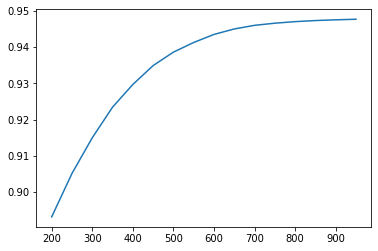

In [256]:
plt.plot(np.arange(200, 1000, 50), eff)

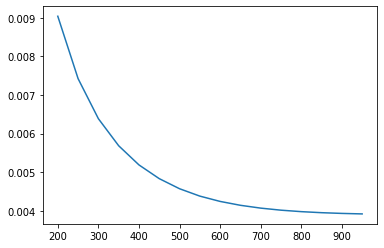

In [257]:
plt.plot(np.arange(200, 1000, 50), pur)

In [240]:
print(true_layerless, true_positive_layerless, positive_layerless)
print(true_layerwise, true_positive_layerwise, positive_layerwise)

99928 94708 24244858
75182 70327 8175009


In [241]:
print("Layerless Eff:", true_positive_layerless/true_layerless, ", Layerless Pur:", true_positive_layerless/positive_layerless)
print("Layerwise Eff:", true_positive_layerwise/true_layerwise, ", Layerwise Pur:", true_positive_layerwise/positive_layerwise)

Layerless Eff: 0.9477623889200224 , Layerless Pur: 0.003906312835488663
Layerwise Eff: 0.9354233726157857 , Layerwise Pur: 0.008602681660656275


In [234]:
print(true_layerless, true_positive_layerless, positive_layerless)
print(true_layerwise, true_positive_layerwise, positive_layerwise)

99928 92660 16190874
75182 68279 5666185


In [235]:
print("Layerless Eff:", true_positive_layerless/true_layerless, ", Layerless Pur:", true_positive_layerless/positive_layerless)
print("Layerwise Eff:", true_positive_layerwise/true_layerwise, ", Layerwise Pur:", true_positive_layerwise/positive_layerwise)

Layerless Eff: 0.9272676326955408 , Layerless Pur: 0.0057229770301467356
Layerwise Eff: 0.9081828097150914 , Layerwise Pur: 0.012050259566180773


In [237]:
print(true_layerless, true_positive_layerless, positive_layerless)
print(true_layerwise, true_positive_layerwise, positive_layerwise)

99928 92866 16800149
75182 68412 5869106


In [238]:
print("Layerless Eff:", true_positive_layerless/true_layerless, ", Layerless Pur:", true_positive_layerless/positive_layerless)
print("Layerwise Eff:", true_positive_layerwise/true_layerwise, ", Layerwise Pur:", true_positive_layerwise/positive_layerwise)

Layerless Eff: 0.9293291169642143 , Layerless Pur: 0.005527689069900511
Layerwise Eff: 0.909951850176904 , Layerwise Pur: 0.011656289731349204


In [109]:
print(true_layerless, true_positive_layerless, positive_layerless)
print(true_layerwise, true_positive_layerwise, positive_layerwise)

99928 88767 36420695
75182 72495 13681815


In [101]:
print("Layerless Eff:", true_positive_layerless/true_layerless, ", Layerless Pur:", true_positive_layerless/positive_layerless)
print("Layerwise Eff:", true_positive_layerwise/true_layerwise, ", Layerwise Pur:", true_positive_layerwise/positive_layerwise)

Layerless Eff: 0.9082239212232808 , Layerless Pur: 0.001986730495740669
Layerwise Eff: 0.9716953526109973 , Layerwise Pur: 0.004367650806037061


In [19]:
batch.x.shape

torch.Size([50086, 3])

In [53]:
batch.event_file

['/global/cscratch1/sd/danieltm/ExaTrkX/trackml/train_all/event000009729']

Text(0.5, 1.0, 'Biadjacent Embedding')

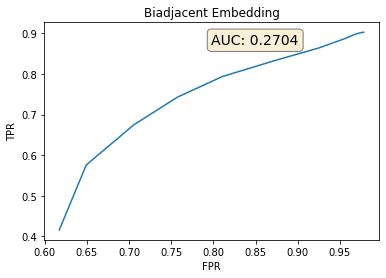

In [75]:
max_ind = np.argmax(pur)

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig, ax = plt.subplots()
ax.plot(1-pur[max_ind:], eff[max_ind:])
ax.text(0.5, 0.95, "AUC: {:.4f}".format(auc(1-pur[max_ind:], eff[max_ind:])), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel("FPR"), ax.set_ylabel("TPR")
ax.set_title("Biadjacent Embedding")

### F1 Results

In [46]:
def evaluate_embedding_f1(test_loader, model, r_min, r_max, r_step):
    
    model.eval()
    
    total_true_positive, total_positive, total_true = np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float), np.zeros(int(np.ceil((r_max - r_min)/r_step)), dtype=np.float)

    for batch in test_loader:

        data = batch.to(device)
        spatial = model(data.x)

        for i, r in enumerate(np.arange(r_min, r_max, r_step)):    
    #         e = radius_graph(emb_feats, r=r, batch=batch.batch, loop=False, max_num_neighbors=5000)

            e_spatial = build_edges(spatial, r, 100, res)
            e_bidir = torch.cat([batch.true_edges.to(device), 
                               torch.stack([batch.true_edges[1], batch.true_edges[0]], axis=1).T.to(device)], axis=-1) 
            array_size = max(e_spatial.max().item(), e_bidir.max().item()) + 1
        
            l1 = e_spatial.cpu().numpy()
            l2 = e_bidir.cpu().numpy()
            e_1 = sp.sparse.coo_matrix((np.ones(l1.shape[1]), l1), shape=(array_size, array_size)).tocsr()
            e_2 = sp.sparse.coo_matrix((np.ones(l2.shape[1]), l2), shape=(array_size, array_size)).tocsr()
            e_final = (e_1.multiply(e_2) - ((e_1 - e_2)>0)).tocoo()

            e_spatial = torch.from_numpy(np.vstack([e_final.row, e_final.col])).long().to(device)
            y = e_final.data > 0

            true = 2*len(batch.true_edges[0])
            true_positive = y.sum()
            positive = len(e_spatial[0])

#             print("True:", true, "Positive:", positive, "True Positive:", true_positive)
            
            total_positive[i] += positive
            total_true[i] += true
            total_true_positive[i] += true_positive

    pur, eff = total_true_positive / total_positive, total_true_positive / total_true
    f1 = 2*pur*eff/(pur+eff)
    return pur, eff, f1

In [47]:
%%time

r_min, r_max, r_step = 0.8, 1.5, 0.1
pur, eff, f1 = evaluate_embedding_f1(test_loader, model, r_min, r_max, r_step)

CPU times: user 4min 40s, sys: 52.8 s, total: 5min 32s
Wall time: 4min 57s


In [48]:
pur, eff

(array([0.26986544, 0.21521619, 0.14788831, 0.08549938, 0.05027146,
        0.03457989, 0.02805509]),
 array([0.73000633, 0.7817497 , 0.82175829, 0.85402927, 0.87859028,
        0.89304132, 0.89871454]))

Text(0.5, 1.0, 'Biadjacent Embedding')

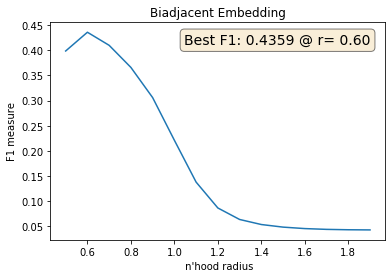

In [74]:
fig, ax = plt.subplots()
ax.plot(np.arange(r_min, r_max, r_step), f1)
ax.text(0.4, 0.95, "Best F1: {:.4f} @ r= {:.2f}".format(max(f1), r_min+r_step*np.argmax(f1)), transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
ax.set_xlabel(" n'hood radius"), ax.set_ylabel("F1 measure")
ax.set_title("Biadjacent Embedding")

### Visualisation

In [70]:
model.eval()
data = test_dataset[2]
data = data.to(device)
spatial = model(data.x)

e_spatial = build_edges(spatial, 1., 100, res)

In [71]:
y_cluster = (data.pid[e_spatial[0]] == data.pid[e_spatial[1]])

In [72]:
e_bidir = torch.cat([data.true_edges.to(device), 
                               torch.stack([data.true_edges[1], data.true_edges[0]], axis=1).T.to(device)], axis=-1) 
        
df0 = pd.DataFrame(e_spatial.cpu().numpy().T)
df1 = pd.DataFrame(e_bidir.cpu().numpy().T)
df_merged = df0.merge(df1, how='left', indicator='Exist')

y = np.where(df_merged.Exist == 'both', 1, 0)

In [73]:
print("Adjacent Pur:", y.sum()/len(df0), "Adjacent Eff:", y.sum()/len(df1), "Global Pur:", y_cluster.sum().item()/len(df0))

Adjacent Pur: 0.21192973793797337 Adjacent Eff: 0.7128364616300568 Global Pur: 0.32751115603543846


In [119]:
e_spatial.shape

torch.Size([2, 274166])

In [82]:
(data.pid[e_spatial[0]] == data.pid[e_spatial[1]] ).sum()

tensor(172510, device='cuda:0')

In [155]:
embedded = spatial.cpu().detach().numpy()
pca = PCA(n_components=3)
px = pca.fit_transform(embedded)

In [ ]:
initial = np.random.choice(e[0])
source_idx = e_spatial[0] == initial
sources = e_spatial[0, source_idx]

target

(9.581162452697754, 12.410853385925293)

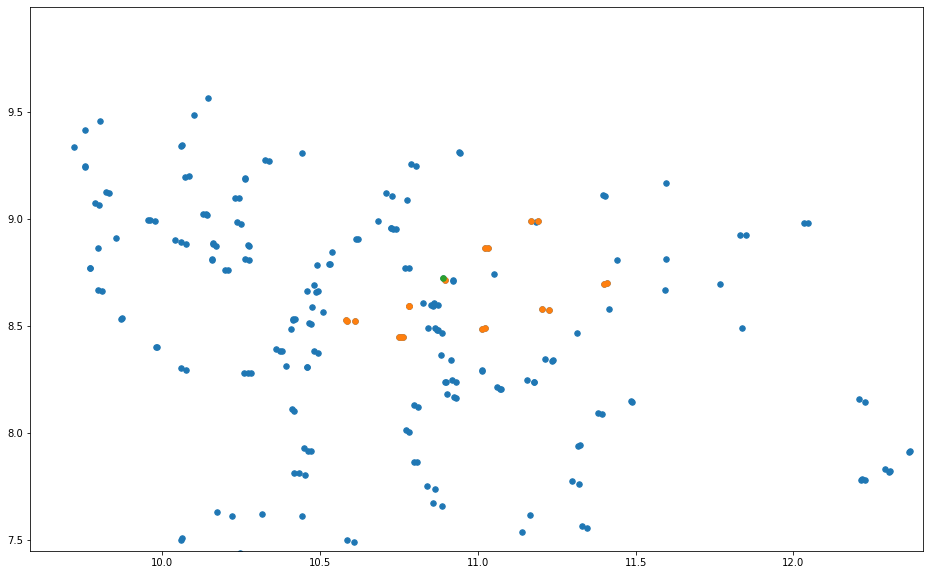

In [157]:
plt.figure(figsize=(16,10))
plt.scatter(px[:,0], px[:,1], s=30)
source = np.random.choice(e_spatial[0].cpu())
targets = e_spatial[1, e_spatial[0,:] == source].cpu()
plt.scatter(px[targets,0], px[targets,1], s=30)
plt.scatter(px[source,0], px[source,1], s=30)
plt.ylim(min(px[targets,1])-1, max(px[targets,1])+1)
plt.xlim(min(px[targets,0])-1, max(px[targets,0])+1)

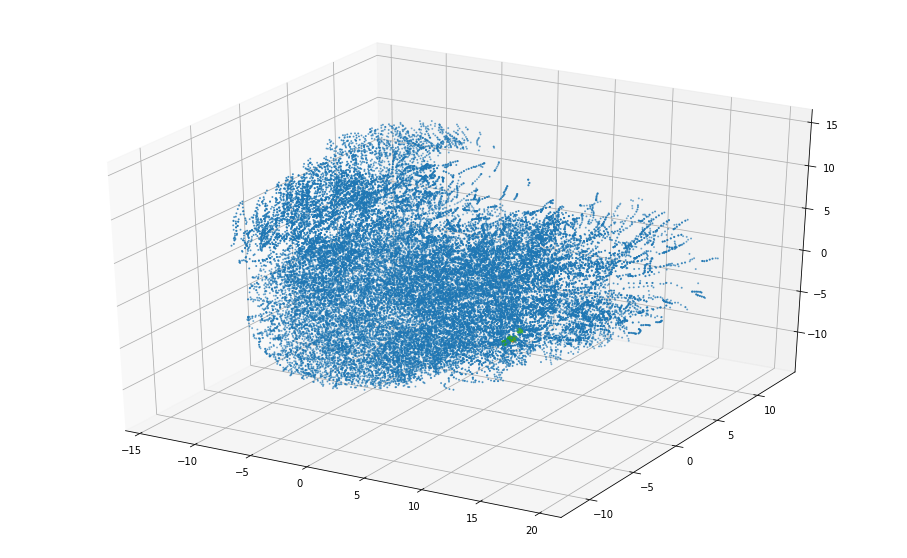

In [133]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px[:,0], px[:,2], px[:,1], s=1)

ax.scatter(px[source,0], px[source,1], px[source,2], s=30)
targets = e_spatial[1, e_spatial[0,:] == source].cpu()
ax.scatter(px[targets,0], px[targets,1], px[targets,2], s=30)

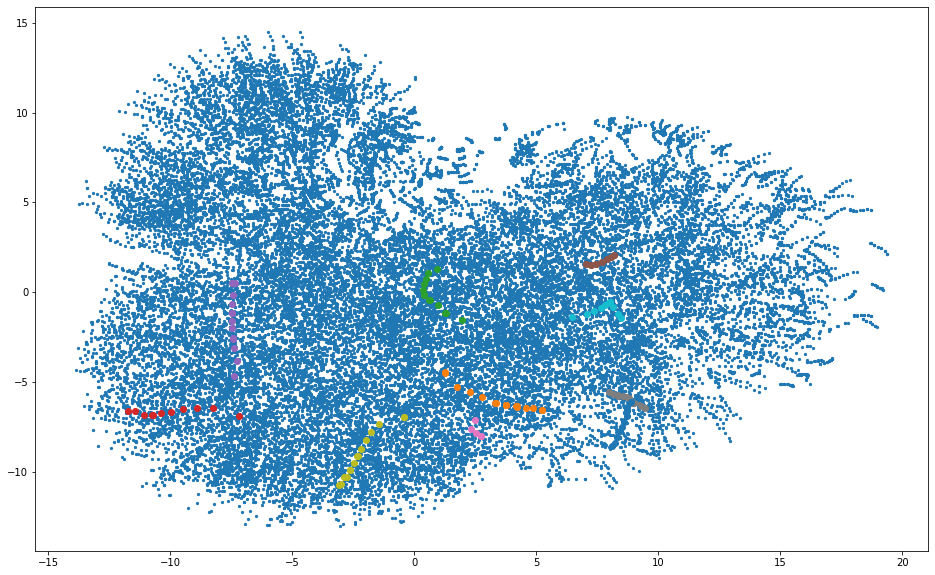

In [134]:
plt.figure(figsize=(16,10))
plt.scatter(px[:,0], px[:,1], s=5)
for P in data.pid.unique()[10:20]:
    Pmask = (data.pid == P).cpu()
    plt.scatter(px[Pmask,0], px[Pmask,1])

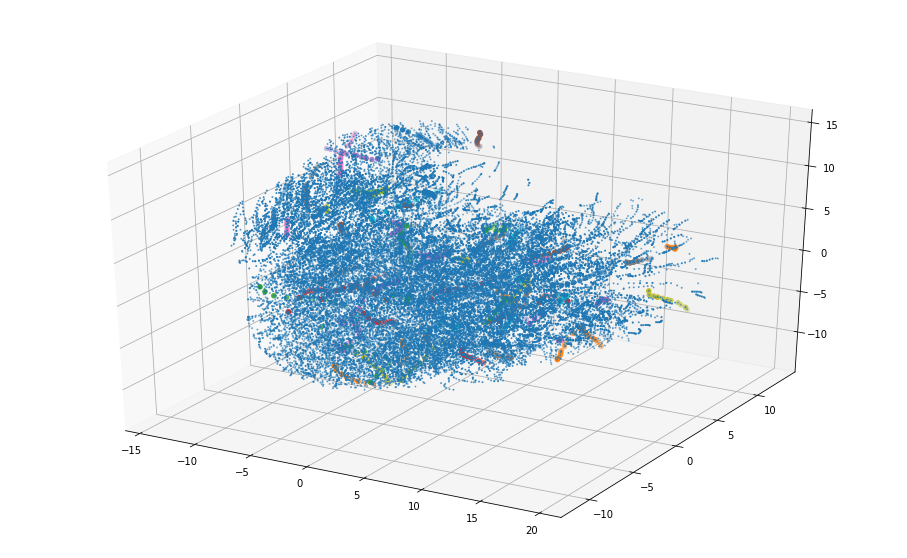

In [142]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(px[:,0], px[:,2], px[:,1], s=1)
for P in data.pid.unique()[::50]:
    Pmask = (data.pid == P).cpu()
    ax.scatter(px[Pmask,0], px[Pmask,2], px[Pmask,1])

First, we prepare the data to be trained on

In [44]:
r = 2.7
step = int((r-r_min)/r_step)
pur[step], eff[step]

(0.17959065291190138, 0.9946552177341628)

In [ ]:
embedding_model = model

In [42]:
filter_train_dataset = [classify_event(model, batch, r=1.4) for batch in train_loader]
filter_test_dataset = [classify_event(model, batch, r=1.4) for batch in test_loader]

In [43]:
filter_train_loader = DataLoader(filter_train_dataset, batch_size=1, shuffle=True)
filter_test_loader = DataLoader(filter_test_dataset, batch_size=1, shuffle=True)

In [ ]:
plt.figure(figsize=(20,10))
x, e, pid = filter_train_dataset[0].x.cpu().numpy(), filter_train_dataset[0].e.cpu().numpy(), filter_train_dataset[0].pid.cpu().numpy()
y = pid[e[0]] == pid[e[1]]
fig = plt.plot([x[e[0,~y], 0], x[e[1,~y], 0]], [x[e[0,~y], 1], x[e[1,~y], 1]] , color='r')
fig = plt.plot([x[e[0,y], 0], x[e[1,y], 0]], [x[e[0,y], 1], x[e[1,y], 1]] , color='k')

For the case of pT>1GeV, filter doesn't seem to have much effect.